In [1]:
import pyspark
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as pyspark_functions
from pyspark import SparkContext, SparkConf
from pandas import isnull
from numpy import count_nonzero
from pyspark.sql.functions import col, count, isnan, when, coalesce, lag, lead, sum
from pyspark.sql.window import Window

import warnings
warnings.filterwarnings("ignore")

In [2]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

In [3]:
# Load the dataset
data = spark.read.csv("D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/dataset/col_mat_nuw_output.csv", header=True, inferSchema=True)

In [4]:
data.printSchema()

root
 |-- 0.00019698343957810148: double (nullable = true)
 |-- Colombo Proper: string (nullable = true)
 |-- 2019-01-01: date (nullable = true)
 |-- 2019-01-02: date (nullable = true)



In [5]:
data.show()

+----------------------+--------------+----------+----------+
|0.00019698343957810148|Colombo Proper|2019-01-01|2019-01-02|
+----------------------+--------------+----------+----------+
|  2.625522171968594...|Colombo Proper|2019-01-02|2019-01-03|
|  9.852118897938794E-5|Colombo Proper|2019-01-03|2019-01-04|
|  2.099320518114242E-4|Colombo Proper|2019-01-04|2019-01-05|
|  1.785337298892930...|Colombo Proper|2019-01-05|2019-01-06|
|  1.082296700235670...|Colombo Proper|2019-01-06|2019-01-07|
|  3.926829280477309...|Colombo Proper|2019-01-07|2019-01-08|
|  9.153156350685351E-5|Colombo Proper|2019-01-08|2019-01-09|
|  1.205978992853015...|Colombo Proper|2019-01-09|2019-01-10|
|  1.297723562983258...|Colombo Proper|2019-01-10|2019-01-11|
|  2.239188166801278...|Colombo Proper|2019-01-11|2019-01-12|
|  1.569418094178759...|Colombo Proper|2019-01-12|2019-01-13|
|                  NULL|Colombo Proper|2019-01-13|2019-01-14|
|  1.336291906862603...|Colombo Proper|2019-01-14|2019-01-15|
|  6.374

In [6]:
column_names = ['HCHO reading', 'Location', 'Current Date', 'Next Date']

# Rename columns using withColumnRenamed()
for i, new_name in enumerate(column_names):
    data = data.withColumnRenamed(data.columns[i], new_name)

# Display the DataFrame
data.show()

+--------------------+--------------+------------+----------+
|        HCHO reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.336291906862603...|Colombo Proper|  2019-01-14|2019-01-15|
|6.37441

In [7]:
# Check unique values of cities
unique_cities = data.select("Location").distinct()
unique_cities.show()

+-------------------+
|           Location|
+-------------------+
|   Deniyaya, Matara|
|     Colombo Proper|
|Nuwara Eliya Proper|
+-------------------+



In [8]:
# Describe the 'HCHO reading' column
data.select('HCHO reading').describe().show()

+-------+--------------------+
|summary|        HCHO reading|
+-------+--------------------+
|  count|                3058|
|   mean|1.200178195763001...|
| stddev|1.009287188756533...|
|    min|-2.59296176552668...|
|    max|8.997101837438971E-4|
+-------+--------------------+



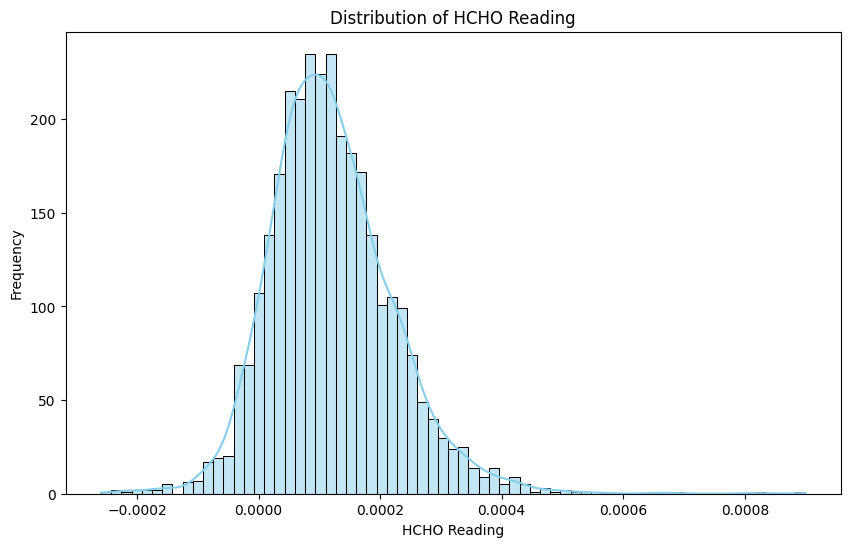

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the "HCHO Reading" column to a Pandas DataFrame for visualization
hcho_df = data.select("HCHO Reading").toPandas()

# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(hcho_df["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Check for null values in the DataFrame
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+------------+--------+------------+---------+
|HCHO reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|        2419|       0|           0|        0|
+------------+--------+------------+---------+



In [11]:
# Initialize a counter for null values
null_count = data.filter(col("HCHO Reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO Reading", 1).over(backward_windowSpec)
    data = data.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO Reading", 1).over(forward_windowSpec)
    data = data.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))
    
    # Update the null count
    null_count = data.filter(col("HCHO Reading").isNull()).count()

# cmn_data now has the nulls filled using a combination of LOCF and NOCB

In [12]:
data.show()

+--------------------+-------------------+------------+----------+
|        HCHO Reading|           Location|Current Date| Next Date|
+--------------------+-------------------+------------+----------+
|2.625522171968594...|   Deniyaya, Matara|  2019-01-01|2019-01-02|
|2.625522171968594...|Nuwara Eliya Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|     Colombo Proper|  2019-01-02|2019-01-03|
|5.803530712000793E-6|   Deniyaya, Matara|  2019-01-02|2019-01-03|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|     Colombo Proper|  2019-01-03|2019-01-04|
|2.362357772653922...|   Deniyaya, Matara|  2019-01-03|2019-01-04|
|1.908293886956784...|Nuwara Eliya Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|     Colombo Proper|  2019-01-04|2019-01-05|
|6.437245753953118E-5|   Deniyaya, Matara|  2019-01-04|2019-01-05|
|5.097625917127737...|Nuwara Eliya Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|     Colombo Proper|  2019-01-05|2019-01

In [13]:
# Count null values in each column
null_counts = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])
null_counts.show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



In [14]:
# Count the number of rows in the DataFrame
data_count = data.count()

# Show the length of the DataFrame
print("Length of DataFrame:", data_count)

Length of DataFrame: 5477


In [15]:
# Drop duplicates from the DataFrame
data_no_duplicates = data.dropDuplicates()

# Show the first few rows of the DataFrame after dropping duplicates
data_no_duplicates.show()

+--------------------+-------------------+------------+----------+
|        HCHO Reading|           Location|Current Date| Next Date|
+--------------------+-------------------+------------+----------+
|2.625522171968594...|   Deniyaya, Matara|  2019-01-01|2019-01-02|
|2.625522171968594...|Nuwara Eliya Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|     Colombo Proper|  2019-01-02|2019-01-03|
|5.803530712000793E-6|   Deniyaya, Matara|  2019-01-02|2019-01-03|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|     Colombo Proper|  2019-01-03|2019-01-04|
|2.362357772653922...|   Deniyaya, Matara|  2019-01-03|2019-01-04|
|1.908293886956784...|Nuwara Eliya Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|     Colombo Proper|  2019-01-04|2019-01-05|
|6.437245753953118E-5|   Deniyaya, Matara|  2019-01-04|2019-01-05|
|5.097625917127737...|Nuwara Eliya Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|     Colombo Proper|  2019-01-05|2019-01

In [16]:
# Count the number of rows in the DataFrame
data_count = data.count()

# Show the length of the DataFrame
print("Length of DataFrame:", data_count)

Length of DataFrame: 5477


In [17]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = data_no_duplicates.toPandas()

# Show the Pandas DataFrame
print(pandas_df)

      HCHO Reading             Location Current Date   Next Date
0         0.000263     Deniyaya, Matara   2019-01-01  2019-01-02
1         0.000263  Nuwara Eliya Proper   2019-01-01  2019-01-02
2         0.000263       Colombo Proper   2019-01-02  2019-01-03
3         0.000006     Deniyaya, Matara   2019-01-02  2019-01-03
4         0.000006  Nuwara Eliya Proper   2019-01-02  2019-01-03
...            ...                  ...          ...         ...
5472      0.000080       Colombo Proper   2023-12-31  2024-01-01
5473      0.000080     Deniyaya, Matara   2023-12-31  2024-01-01
5474      0.000080  Nuwara Eliya Proper   2023-12-31  2024-01-01
5475      0.000254       Colombo Proper   2022-03-07  2022-03-08
5476      0.000029     Deniyaya, Matara   2022-07-10  2022-07-11

[5477 rows x 4 columns]


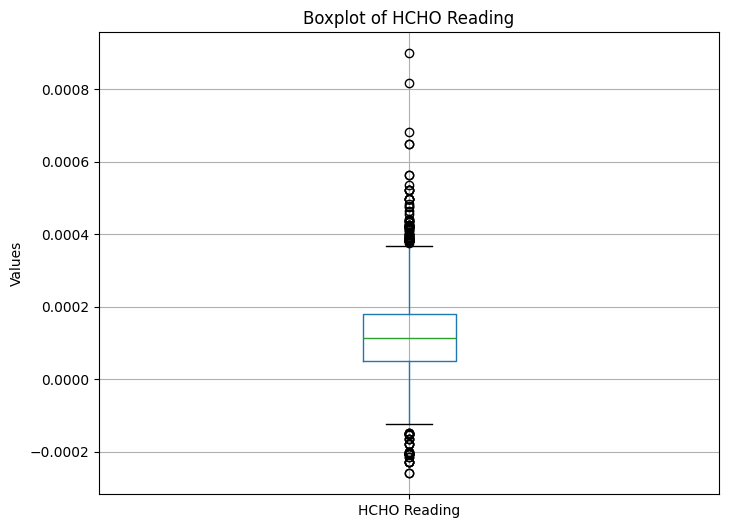

In [19]:
import matplotlib.pyplot as plt

feature = "HCHO Reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df.boxplot(column=[feature])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()


In [20]:
import numpy as np


# Extracting the HCHO readings
hcho_readings = pandas_df[feature]

# Calculating quartiles and IQR
Q1 = hcho_readings.quantile(0.25)
Q3 = hcho_readings.quantile(0.75)
IQR = Q3 - Q1

# Defining outlier thresholds
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

# Counting outliers
outliers_frequency = ((hcho_readings < lower_threshold) | (hcho_readings > upper_threshold)).sum()

print("Frequency of outliers:", outliers_frequency)


Frequency of outliers: 112


In [21]:
# Define the Winsorization function
def winsorize(series, lower_threshold, upper_threshold):
    # Winsorize the series
    winsorized_series = series.clip(lower=lower_threshold, upper=upper_threshold)
    return winsorized_series

# Apply Winsorization to handle outliers
pandas_df[feature] = winsorize(pandas_df[feature], lower_threshold, upper_threshold)

# Recalculate the frequency of outliers after Winsorization
outliers_after_winsorization = ((pandas_df[feature] < lower_threshold) | (pandas_df[feature] > upper_threshold)).sum()

print("Frequency of outliers after Winsorization:", outliers_after_winsorization)


Frequency of outliers after Winsorization: 0


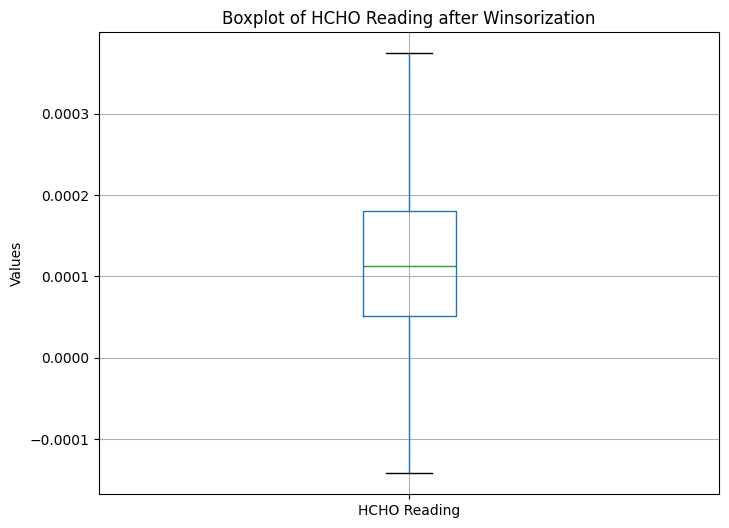

In [22]:
import matplotlib.pyplot as plt

# Plot boxplot for the Winsorized feature
plt.figure(figsize=(8, 6))
pandas_df.boxplot(column=[feature])
plt.title(f'Boxplot of {feature} after Winsorization')
plt.ylabel('Values')
plt.show()


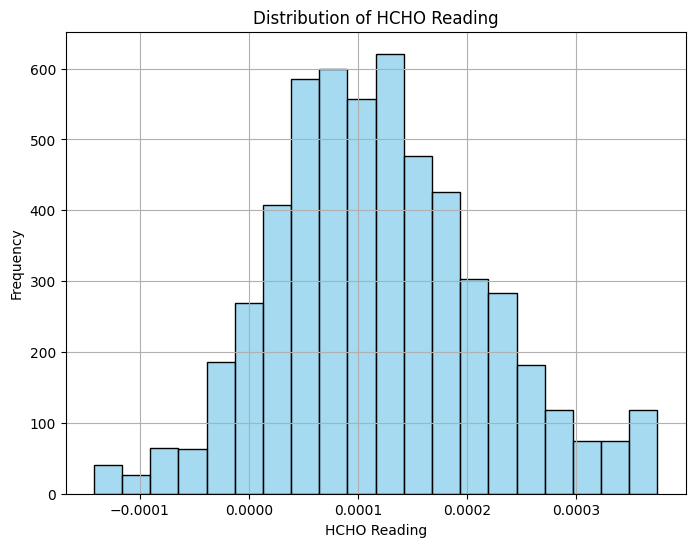

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting the feature "HCHO Reading"
feature = "HCHO Reading"

# Plot histogram for the selected feature
plt.figure(figsize=(8, 6))
sns.histplot(pandas_df[feature], bins=20, color='skyblue', edgecolor='black')
plt.title(f'Distribution of {feature}')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [23]:
pandas_df

,HCHO Reading,Location,Current Date,Next Date
0,0.000263,"Deniyaya, Matara",2019-01-01,2019-01-02
1,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02
2,0.000263,Colombo Proper,2019-01-02,2019-01-03
3,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03
4,0.000006,Nuwara Eliya Proper,2019-01-02,2019-01-03
...,...,...,...,...
5472,0.000080,Colombo Proper,2023-12-31,2024-01-01
5473,0.000080,"Deniyaya, Matara",2023-12-31,2024-01-01
5474,0.000080,Nuwara Eliya Proper,2023-12-31,2024-01-01
5475,0.000254,Colombo Proper,2022-03-07,2022-03-08


In [24]:
for unique_value in sorted(pandas_df['HCHO Reading'].unique()):
    print(unique_value)

-0.0001421363788920575
-0.0001226669264724478
-0.00012023889831895004
-0.00011799253267575614
-0.00011215378939636268
-0.0001089299252098114
-0.00010849980753846467
-9.896915283582645e-05
-9.875609976006672e-05
-9.762795257692533e-05
-9.75290000242051e-05
-9.728603617986664e-05
-9.656306209314945e-05
-9.530893663843814e-05
-8.969503664672427e-05
-8.888445964777543e-05
-8.613132454580255e-05
-8.562912389164453e-05
-8.45016286786133e-05
-8.4192331214536e-05
-8.416679327042497e-05
-8.375765006525143e-05
-8.23189832577379e-05
-8.034903995154305e-05
-7.923249506633774e-05
-7.767660943011708e-05
-7.744679386709862e-05
-7.690615160913287e-05
-7.58294658224229e-05
-7.581763929920271e-05
-7.534215509575606e-05
-7.246725134238776e-05
-7.171403386199247e-05
-7.139582778127925e-05
-7.127528630831339e-05
-7.03567768815656e-05
-7.020741959235938e-05
-6.92390668412229e-05
-6.916265567256713e-05
-6.800550885402525e-05
-6.789071314300927e-05
-6.758583905496734e-05
-6.670656110435048e-05
-6.649297855973

In [25]:
for unique_value in sorted(pandas_df['Location'].unique()):
    print(unique_value)

Colombo Proper
Deniyaya, Matara
Nuwara Eliya Proper


In [26]:
for unique_value in sorted(pandas_df['Current Date'].unique()):
    print(unique_value)

2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05
2019-03-06
2019-03-07
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-12
2019-03-13
2019-03-14
2019-03-15
2019-03-16
2019-03-17
2019-03-18
2019-03-19
2019-03-20
2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01

In [27]:
import pandas as pd

dates = pandas_df['Current Date']

for date in sorted(dates.unique()):
    try:
        pd.to_datetime(date)
    except ValueError:
        print(f"Invalid date format: {date}")

In [28]:
for unique_value in sorted(pandas_df['Next Date'].unique()):
    print(unique_value)

2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05
2019-03-06
2019-03-07
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-12
2019-03-13
2019-03-14
2019-03-15
2019-03-16
2019-03-17
2019-03-18
2019-03-19
2019-03-20
2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01
2019-04-02

In [29]:
import pandas as pd

dates_2 = pandas_df['Next Date']

for date in sorted(dates_2.unique()):
    try:
        pd.to_datetime(date)
    except ValueError:
        print(f"Invalid date format: {date}")

In [30]:
pandas_df

,HCHO Reading,Location,Current Date,Next Date
0,0.000263,"Deniyaya, Matara",2019-01-01,2019-01-02
1,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02
2,0.000263,Colombo Proper,2019-01-02,2019-01-03
3,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03
4,0.000006,Nuwara Eliya Proper,2019-01-02,2019-01-03
...,...,...,...,...
5472,0.000080,Colombo Proper,2023-12-31,2024-01-01
5473,0.000080,"Deniyaya, Matara",2023-12-31,2024-01-01
5474,0.000080,Nuwara Eliya Proper,2023-12-31,2024-01-01
5475,0.000254,Colombo Proper,2022-03-07,2022-03-08


In [31]:
import pandas as pd

#Save preprocessed dataset
pandas_df.to_csv('D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/preprocessed dataset/preprocessed_dataset.csv', index=False)

# Import 2nd Dataset

In [32]:
# Load the dataset
data_2 = spark.read.csv("D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/dataset/kan_output.csv", header=True, inferSchema=True)

In [33]:
data_2.printSchema()

root
 |-- 0.00017607134598773356: double (nullable = true)
 |-- Kandy Proper: string (nullable = true)
 |-- 2019-01-01: date (nullable = true)
 |-- 2019-01-02: date (nullable = true)



In [34]:
data.show()

+--------------------+-------------------+------------+----------+
|        HCHO Reading|           Location|Current Date| Next Date|
+--------------------+-------------------+------------+----------+
|2.625522171968594...|   Deniyaya, Matara|  2019-01-01|2019-01-02|
|2.625522171968594...|Nuwara Eliya Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|     Colombo Proper|  2019-01-02|2019-01-03|
|5.803530712000793E-6|   Deniyaya, Matara|  2019-01-02|2019-01-03|
|5.803530712000793E-6|Nuwara Eliya Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|     Colombo Proper|  2019-01-03|2019-01-04|
|2.362357772653922...|   Deniyaya, Matara|  2019-01-03|2019-01-04|
|1.908293886956784...|Nuwara Eliya Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|     Colombo Proper|  2019-01-04|2019-01-05|
|6.437245753953118E-5|   Deniyaya, Matara|  2019-01-04|2019-01-05|
|5.097625917127737...|Nuwara Eliya Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|     Colombo Proper|  2019-01-05|2019-01

In [35]:
column_names_2 = ['HCHO reading', 'Location', 'Current Date', 'Next Date']

# Rename columns using withColumnRenamed()
for i, new_name in enumerate(column_names_2):
    data_2 = data_2.withColumnRenamed(data_2.columns[i], new_name)

# Display the DataFrame
data_2.show()

+--------------------+------------+------------+----------+
|        HCHO reading|    Location|Current Date| Next Date|
+--------------------+------------+------------+----------+
|9.220391253917748E-5|Kandy Proper|  2019-01-02|2019-01-03|
|                NULL|Kandy Proper|  2019-01-03|2019-01-04|
|1.908681983853839...|Kandy Proper|  2019-01-04|2019-01-05|
|1.219517840206744...|Kandy Proper|  2019-01-05|2019-01-06|
|-6.51408612938880...|Kandy Proper|  2019-01-06|2019-01-07|
|  1.6323820639265E-4|Kandy Proper|  2019-01-07|2019-01-08|
|-6.73520553391426...|Kandy Proper|  2019-01-08|2019-01-09|
|1.279693658243135...|Kandy Proper|  2019-01-09|2019-01-10|
|4.546048424126012E-5|Kandy Proper|  2019-01-10|2019-01-11|
|3.600074175192105E-5|Kandy Proper|  2019-01-11|2019-01-12|
|1.286629698010177E-4|Kandy Proper|  2019-01-12|2019-01-13|
|                NULL|Kandy Proper|  2019-01-13|2019-01-14|
|                NULL|Kandy Proper|  2019-01-14|2019-01-15|
| 9.63639634671553E-5|Kandy Proper|  201

In [36]:
# Describe the 'HCHO reading' column
data_2.select('HCHO reading').describe().show()

+-------+--------------------+
|summary|        HCHO reading|
+-------+--------------------+
|  count|                1032|
|   mean|1.063085614635522...|
| stddev|9.204472306341158E-5|
|    min|-2.99702863135199...|
|    max|7.051621763962024E-4|
+-------+--------------------+



In [37]:
# Get the number of rows
num_rows = data_2.count()

# Get the number of columns
num_columns = len(data_2.columns)

# Print the shape
print("Shape of the DataFrame: {} rows, {} columns".format(num_rows, num_columns))

Shape of the DataFrame: 1825 rows, 4 columns


In [38]:
data_2.printSchema()

root
 |-- HCHO reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)



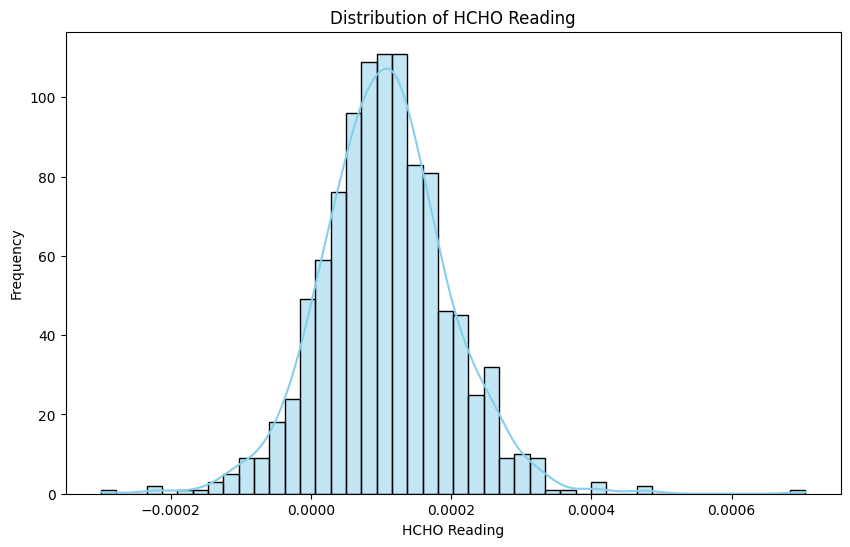

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the "HCHO Reading" column to a Pandas DataFrame for visualization
hcho_df_2 = data_2.select("HCHO Reading").toPandas()

# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(hcho_df_2 ["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()


In [40]:

# Check for null values in the DataFrame
data_2.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|         793|       0|           0|        0|
+------------+--------+------------+---------+



In [41]:
from pyspark.sql.window import Window
from pyspark.sql.functions import coalesce, col, lag, lead, count

# Initialize a counter for null values
null_count_2 = data_2.filter(col("HCHO Reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count_2 > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO Reading", 1).over(backward_windowSpec)
    data_2 = data_2.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO Reading", 1).over(forward_windowSpec)
    data_2 = data_2.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))
    
    # Update the null count
    null_count_2 = data_2.filter(col("HCHO Reading").isNull()).count()


In [42]:
from pyspark.sql.functions import col, sum as spark_sum, when

columns_2 = data_2.columns

# Calculate missing values for each column
missing_counts_2 = data_2.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns_2])

# Show missing counts
missing_counts_2.show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



In [43]:
pandas_df_2 = data_2.toPandas()
pandas_df_2

,HCHO Reading,Location,Current Date,Next Date
0,0.000092,Kandy Proper,2019-01-02,2019-01-03
1,0.000092,Kandy Proper,2019-01-03,2019-01-04
2,0.000191,Kandy Proper,2019-01-04,2019-01-05
3,0.000122,Kandy Proper,2019-01-05,2019-01-06
4,-0.000065,Kandy Proper,2019-01-06,2019-01-07
...,...,...,...,...
1820,0.000056,Kandy Proper,2023-12-27,2023-12-28
1821,0.000056,Kandy Proper,2023-12-28,2023-12-29
1822,0.000056,Kandy Proper,2023-12-29,2023-12-30
1823,0.000056,Kandy Proper,2023-12-30,2023-12-31


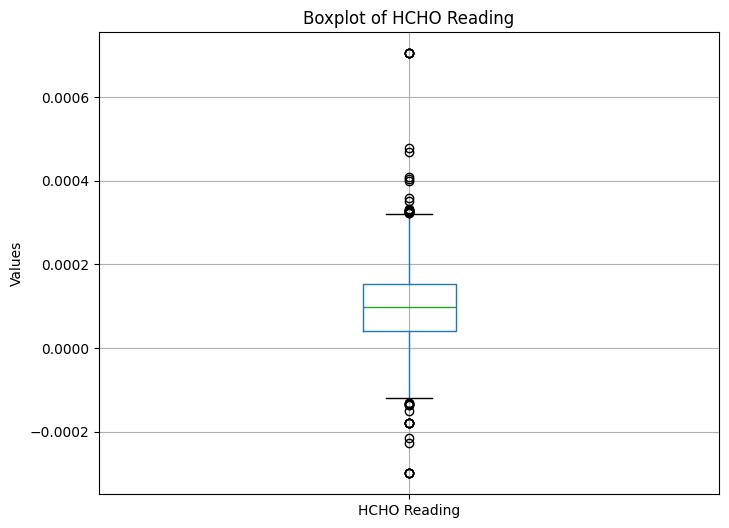

In [45]:
import matplotlib.pyplot as plt

feature_2 = "HCHO Reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df_2.boxplot(column=[feature_2])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()

In [46]:
hcho_readings_2 = pandas_df_2[feature_2]

# Calculating quartiles and IQR
Q1_2 = hcho_readings_2.quantile(0.25)
Q3_2 = hcho_readings_2.quantile(0.75)
IQR_2 = Q3_2 - Q1_2

# Defining outlier thresholds
lower_threshold_2 = Q1_2 - 1.5 * IQR_2
upper_threshold_2 = Q3_2 + 1.5 * IQR_2

# Counting outliers
outliers_frequency_2 = ((hcho_readings_2 < lower_threshold_2) | (hcho_readings_2 > upper_threshold_2)).sum()

print("Frequency of outliers in feature_2:", outliers_frequency_2)



Frequency of outliers in feature_2: 43


In [47]:
# Define the Winsorization function
def winsorize(series, lower_threshold, upper_threshold):
    # Winsorize the series
    winsorized_series = series.clip(lower=lower_threshold, upper=upper_threshold)
    return winsorized_series

# Apply Winsorization to handle outliers
pandas_df_2[feature_2] = winsorize(pandas_df_2[feature_2], lower_threshold_2, upper_threshold_2)

# Recalculate the frequency of outliers after Winsorization
outliers_after_winsorization_2 = ((pandas_df_2[feature_2] < lower_threshold_2) | (pandas_df_2[feature_2] > upper_threshold_2)).sum()

print("Frequency of outliers after Winsorization in feature_2:", outliers_after_winsorization_2)


Frequency of outliers after Winsorization in feature_2: 0


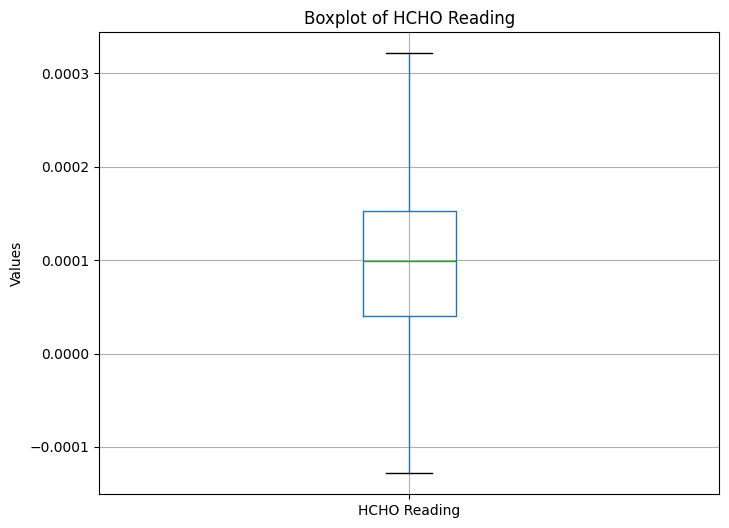

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns


# Selecting the feature "HCHO Reading"
feature = "HCHO Reading"

# Plot histogram for the selected feature
plt.figure(figsize=(8, 6))
sns.histplot(pandas_df[feature], bins=20, color='skyblue', edgecolor='black')
plt.title(f'Distribution of {feature}')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


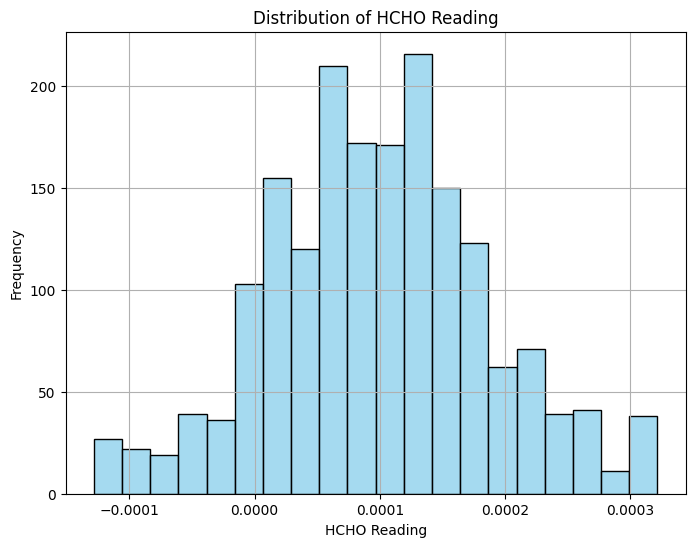

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming pandas_df_1 is your Pandas DataFrame

# Selecting the feature "HCHO Reading"
feature_2 = "HCHO Reading"

# Plot histogram for the selected feature
plt.figure(figsize=(8, 6))
sns.histplot(pandas_df_2[feature_2], bins=20, color='skyblue', edgecolor='black')
plt.title(f'Distribution of {feature_2}')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [49]:
pandas_df_2

,HCHO Reading,Location,Current Date,Next Date
0,0.000092,Kandy Proper,2019-01-02,2019-01-03
1,0.000092,Kandy Proper,2019-01-03,2019-01-04
2,0.000191,Kandy Proper,2019-01-04,2019-01-05
3,0.000122,Kandy Proper,2019-01-05,2019-01-06
4,-0.000065,Kandy Proper,2019-01-06,2019-01-07
...,...,...,...,...
1820,0.000056,Kandy Proper,2023-12-27,2023-12-28
1821,0.000056,Kandy Proper,2023-12-28,2023-12-29
1822,0.000056,Kandy Proper,2023-12-29,2023-12-30
1823,0.000056,Kandy Proper,2023-12-30,2023-12-31


In [50]:
for unique_value in sorted(pandas_df_2['HCHO Reading'].unique()):
    print(unique_value)

-0.00012825599879010837
-0.00011972465671369591
-0.00011102503012718791
-0.00010953149395993691
-0.00010505652825361387
-0.00010421431136271193
-0.00010153305191015103
-0.00010142346317757635
-9.997653983236062e-05
-9.744629293521989e-05
-9.723458801103359e-05
-9.640269790807805e-05
-9.298285259082747e-05
-9.03955878775148e-05
-8.405673784804399e-05
-8.121993178601313e-05
-7.823375594718562e-05
-7.303543319663562e-05
-7.114043515272996e-05
-6.735205533914268e-05
-6.719856740310691e-05
-6.514086129388805e-05
-6.488176666242177e-05
-6.311605132129754e-05
-5.9145160006379786e-05
-5.8307068595810777e-05
-5.821006164510963e-05
-5.498078483761552e-05
-5.460778700422602e-05
-5.450984014903148e-05
-5.314761711384331e-05
-5.1735860332476076e-05
-4.821809128200573e-05
-4.6999528422020376e-05
-4.5702171118002286e-05
-4.553184436542499e-05
-4.533776899965042e-05
-4.21289315108277e-05
-4.1407437548567194e-05
-4.0288898409749716e-05
-4.018462979616311e-05
-3.8821261724315655e-05
-3.690479764579448e-

In [51]:
for unique_value in sorted(pandas_df_2['Location'].unique()):
    print(unique_value)

Kandy Proper


In [52]:
for unique_value in sorted(pandas_df_2['Current Date'].unique()):
    print(unique_value)

2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05
2019-03-06
2019-03-07
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-12
2019-03-13
2019-03-14
2019-03-15
2019-03-16
2019-03-17
2019-03-18
2019-03-19
2019-03-20
2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01
2019-04-02

In [53]:
import pandas as pd

# Assuming pandas_df_1 is your DataFrame
dates = pandas_df_2['Current Date']

for date in sorted(dates.unique()):
    try:
        pd.to_datetime(date)
    except ValueError:
        print(f"Invalid date format: {date}")

In [54]:
for unique_value in sorted(pandas_df_2['Next Date'].unique()):
    print(unique_value)

2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05
2019-03-06
2019-03-07
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-12
2019-03-13
2019-03-14
2019-03-15
2019-03-16
2019-03-17
2019-03-18
2019-03-19
2019-03-20
2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01
2019-04-02
2019-04-03

In [55]:
import pandas as pd

dates = pandas_df_2['Next Date']

for date in sorted(dates.unique()):
    try:
        pd.to_datetime(date)
    except ValueError:
        print(f"Invalid date format: {date}")

In [56]:
pandas_df_2

,HCHO Reading,Location,Current Date,Next Date
0,0.000092,Kandy Proper,2019-01-02,2019-01-03
1,0.000092,Kandy Proper,2019-01-03,2019-01-04
2,0.000191,Kandy Proper,2019-01-04,2019-01-05
3,0.000122,Kandy Proper,2019-01-05,2019-01-06
4,-0.000065,Kandy Proper,2019-01-06,2019-01-07
...,...,...,...,...
1820,0.000056,Kandy Proper,2023-12-27,2023-12-28
1821,0.000056,Kandy Proper,2023-12-28,2023-12-29
1822,0.000056,Kandy Proper,2023-12-29,2023-12-30
1823,0.000056,Kandy Proper,2023-12-30,2023-12-31


In [57]:
import pandas as pd

#Save preprocessed dataset
pandas_df_2.to_csv('D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/preprocessed dataset/preprocessed_dataset_2.csv', index=False) 

# Import 3rd Dataset

In [58]:
# Load the dataset
data_3 = spark.read.csv("D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/dataset/mon_kur_jaf_output.csv", header=True, inferSchema=True)

In [59]:
data_3.printSchema()

root
 |-- _c0: double (nullable = true)
 |-- Bibile, Monaragala: string (nullable = true)
 |-- 2019-01-01: date (nullable = true)
 |-- 2019-01-02: date (nullable = true)



In [60]:
data_3.show()

+--------------------+------------------+----------+----------+
|                 _c0|Bibile, Monaragala|2019-01-01|2019-01-02|
+--------------------+------------------+----------+----------+
|1.919914652467399E-5|Bibile, Monaragala|2019-01-02|2019-01-03|
|2.811447935930283...|Bibile, Monaragala|2019-01-03|2019-01-04|
|3.747998184385943E-5|Bibile, Monaragala|2019-01-04|2019-01-05|
|-1.79826087934531...|Bibile, Monaragala|2019-01-05|2019-01-06|
|1.457836896179902...|Bibile, Monaragala|2019-01-06|2019-01-07|
|2.828590802546534...|Bibile, Monaragala|2019-01-07|2019-01-08|
|                NULL|Bibile, Monaragala|2019-01-08|2019-01-09|
|1.420850167050957...|Bibile, Monaragala|2019-01-09|2019-01-10|
|                NULL|Bibile, Monaragala|2019-01-10|2019-01-11|
|2.014587947072581E-5|Bibile, Monaragala|2019-01-11|2019-01-12|
|1.582787663210183...|Bibile, Monaragala|2019-01-12|2019-01-13|
|                NULL|Bibile, Monaragala|2019-01-13|2019-01-14|
|                NULL|Bibile, Monaragala

In [61]:
column_names_3 = ['HCHO reading', 'Location', 'Current Date', 'Next Date']

# Rename columns using withColumnRenamed()
for i, new_name in enumerate(column_names_3):
    data_3 = data_3.withColumnRenamed(data_3.columns[i], new_name)

# Display the DataFrame
data_3.show()

+--------------------+------------------+------------+----------+
|        HCHO reading|          Location|Current Date| Next Date|
+--------------------+------------------+------------+----------+
|1.919914652467399E-5|Bibile, Monaragala|  2019-01-02|2019-01-03|
|2.811447935930283...|Bibile, Monaragala|  2019-01-03|2019-01-04|
|3.747998184385943E-5|Bibile, Monaragala|  2019-01-04|2019-01-05|
|-1.79826087934531...|Bibile, Monaragala|  2019-01-05|2019-01-06|
|1.457836896179902...|Bibile, Monaragala|  2019-01-06|2019-01-07|
|2.828590802546534...|Bibile, Monaragala|  2019-01-07|2019-01-08|
|                NULL|Bibile, Monaragala|  2019-01-08|2019-01-09|
|1.420850167050957...|Bibile, Monaragala|  2019-01-09|2019-01-10|
|                NULL|Bibile, Monaragala|  2019-01-10|2019-01-11|
|2.014587947072581E-5|Bibile, Monaragala|  2019-01-11|2019-01-12|
|1.582787663210183...|Bibile, Monaragala|  2019-01-12|2019-01-13|
|                NULL|Bibile, Monaragala|  2019-01-13|2019-01-14|
|         

In [62]:
# Describe the 'HCHO reading' column
data_3.select('HCHO reading').describe().show()


+-------+--------------------+
|summary|        HCHO reading|
+-------+--------------------+
|  count|                3826|
|   mean|1.221495984357837E-4|
| stddev|8.663968642569532E-5|
|    min|-3.52473024357239...|
|    max|5.837611392919413E-4|
+-------+--------------------+



In [63]:
# Get the number of rows
num_rows = data_3.count()

# Get the number of columns
num_columns = len(data_3.columns)

# Print the shape
print("Shape of the DataFrame: {} rows, {} columns".format(num_rows, num_columns))

Shape of the DataFrame: 5477 rows, 4 columns


In [64]:
data_3.printSchema()

root
 |-- HCHO reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)



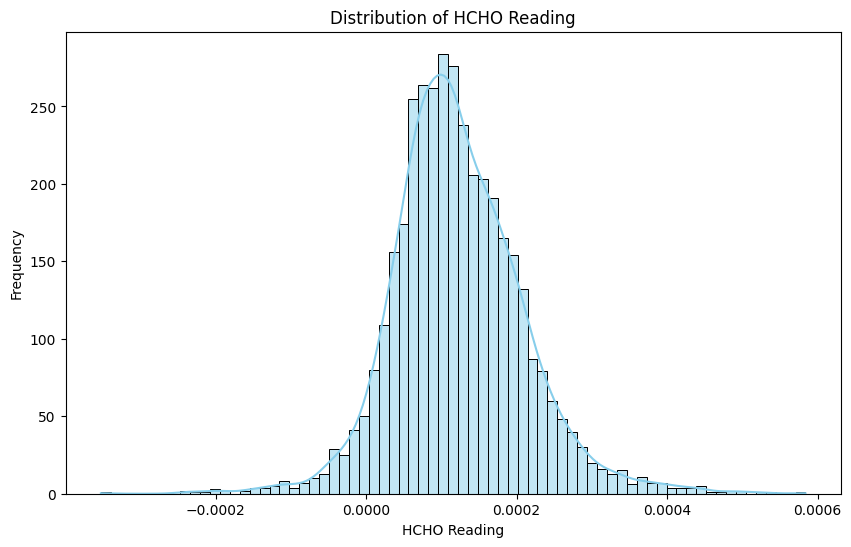

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the "HCHO Reading" column to a Pandas DataFrame for visualization
hcho_df_3 = data_3.select("HCHO Reading").toPandas()

# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(hcho_df_3["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()

In [66]:
# Check for null values in the DataFrame
data_3.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|        1651|       0|           0|        0|
+------------+--------+------------+---------+



In [67]:
from pyspark.sql.window import Window
from pyspark.sql.functions import coalesce, col, lag, lead, count

# Initialize a counter for null values
null_count_3 = data_3.filter(col("HCHO Reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count_3 > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO Reading", 1).over(backward_windowSpec)
    data_3 = data_3.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO Reading", 1).over(forward_windowSpec)
    data_3 = data_3.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))
    
    # Update the null count
    null_count_3 = data_3.filter(col("HCHO Reading").isNull()).count()


In [68]:
from pyspark.sql.functions import col, sum as spark_sum, when

columns_3 = data_3.columns

# Calculate missing values for each column
missing_counts_3 = data_3.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns_3])

# Show missing counts
missing_counts_3.show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



In [69]:
pandas_df_3 = data_3.toPandas()
pandas_df_3

,HCHO Reading,Location,Current Date,Next Date
0,0.000088,Kurunegala Proper,2019-01-01,2019-01-02
1,0.000058,Jaffna Proper,2019-01-01,2019-01-02
2,0.000019,"Bibile, Monaragala",2019-01-02,2019-01-03
3,0.000137,Kurunegala Proper,2019-01-02,2019-01-03
4,0.000102,Jaffna Proper,2019-01-02,2019-01-03
...,...,...,...,...
5472,0.000158,Kurunegala Proper,2023-12-30,2023-12-31
5473,0.000117,Jaffna Proper,2023-12-30,2023-12-31
5474,0.000117,"Bibile, Monaragala",2023-12-31,2024-01-01
5475,0.000065,Kurunegala Proper,2023-12-31,2024-01-01


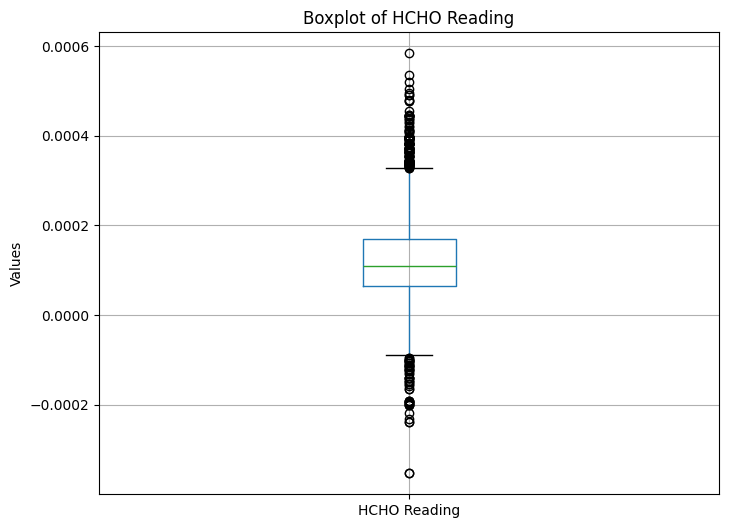

In [71]:
import matplotlib.pyplot as plt

feature_3 = "HCHO Reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df_3.boxplot(column=[feature_3])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()

In [72]:
# Extracting the HCHO readings from pandas_df_3
hcho_readings_3 = pandas_df_3[feature_3]

# Calculating quartiles and IQR
Q1_3 = hcho_readings_3.quantile(0.25)
Q3_3 = hcho_readings_3.quantile(0.75)
IQR_3 = Q3_3 - Q1_3

# Defining outlier thresholds
lower_threshold_3 = Q1_3 - 1.5 * IQR_3
upper_threshold_3 = Q3_3 + 1.5 * IQR_3

# Counting outliers
outliers_frequency_3 = ((hcho_readings_3 < lower_threshold_3) | (hcho_readings_3 > upper_threshold_3)).sum()

print("Frequency of outliers in feature_3:", outliers_frequency_3)


Frequency of outliers in feature_3: 179


In [73]:
# Define the Winsorization function
def winsorize(series, lower_threshold, upper_threshold):
    # Winsorize the series
    winsorized_series = series.clip(lower=lower_threshold, upper=upper_threshold)
    return winsorized_series

# Apply Winsorization to handle outliers
pandas_df_3[feature_3] = winsorize(pandas_df_3[feature_3], lower_threshold_3, upper_threshold_3)

# Recalculate the frequency of outliers after Winsorization
outliers_after_winsorization_3 = ((pandas_df_3[feature_3] < lower_threshold_3) | (pandas_df_3[feature_3] > upper_threshold_3)).sum()

print("Frequency of outliers after Winsorization in feature_3:", outliers_after_winsorization_3)


Frequency of outliers after Winsorization in feature_3: 0


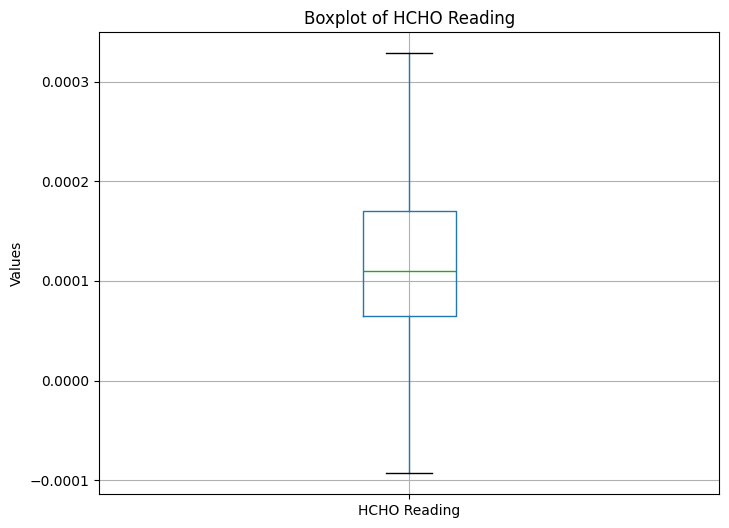

In [74]:
import matplotlib.pyplot as plt

feature_3 = "HCHO Reading"

# Plot boxplot for the selected feature
plt.figure(figsize=(8, 6))
pandas_df_3.boxplot(column=[feature_3])
plt.title(f'Boxplot of {feature}')
plt.ylabel('Values')
plt.show()

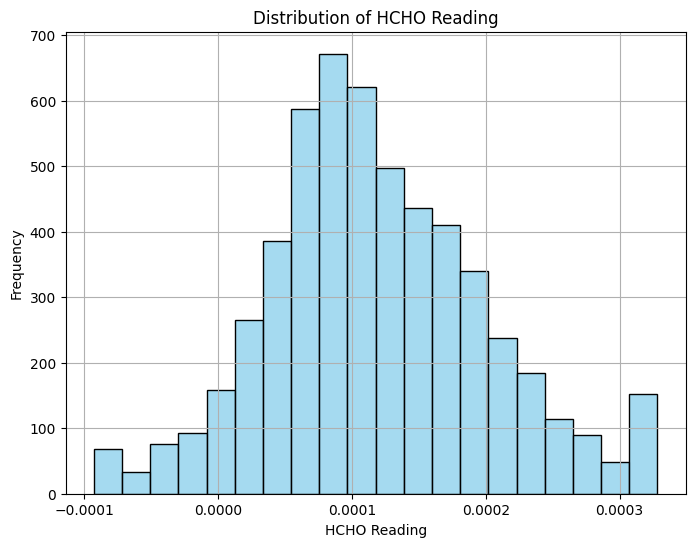

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting the feature "HCHO Reading"
feature_3 = "HCHO Reading"

# Plot histogram for the selected feature
plt.figure(figsize=(8, 6))
sns.histplot(pandas_df_3[feature_3], bins=20, color='skyblue', edgecolor='black')
plt.title(f'Distribution of {feature}')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [75]:
pandas_df_3

,HCHO Reading,Location,Current Date,Next Date
0,0.000088,Kurunegala Proper,2019-01-01,2019-01-02
1,0.000058,Jaffna Proper,2019-01-01,2019-01-02
2,0.000019,"Bibile, Monaragala",2019-01-02,2019-01-03
3,0.000137,Kurunegala Proper,2019-01-02,2019-01-03
4,0.000102,Jaffna Proper,2019-01-02,2019-01-03
...,...,...,...,...
5472,0.000158,Kurunegala Proper,2023-12-30,2023-12-31
5473,0.000117,Jaffna Proper,2023-12-30,2023-12-31
5474,0.000117,"Bibile, Monaragala",2023-12-31,2024-01-01
5475,0.000065,Kurunegala Proper,2023-12-31,2024-01-01


In [76]:
for unique_value in sorted(pandas_df_3['HCHO Reading'].unique()):
    print(unique_value)

-9.300845810525634e-05
-8.871085539815838e-05
-8.7612250354141e-05
-8.336398007201524e-05
-8.249573147622868e-05
-8.232762056067805e-05
-8.152057093708102e-05
-7.817408913979307e-05
-7.228200424818833e-05
-7.15909409699863e-05
-6.91114370543075e-05
-6.727133903549927e-05
-6.67326523360897e-05
-6.538889368742119e-05
-6.440251342276223e-05
-6.385750734361702e-05
-6.380867365829729e-05
-6.312741217644393e-05
-6.145898821479466e-05
-5.970363291286597e-05
-5.8506497870336726e-05
-5.80993000033222e-05
-5.758271115724228e-05
-5.631724408819705e-05
-5.5806945096190965e-05
-5.382137991659866e-05
-5.2935063658280796e-05
-5.2767861370760775e-05
-5.167498118720221e-05
-5.101817082685539e-05
-5.1007204990354926e-05
-4.907189204896407e-05
-4.886700358960491e-05
-4.8082885768963024e-05
-4.798950304656565e-05
-4.7947211397727374e-05
-4.753552551857047e-05
-4.7006032850858336e-05
-4.671209171647206e-05
-4.658733229933503e-05
-4.614213674005632e-05
-4.5988090400380006e-05
-4.586836205932822e-05
-4.52647

In [77]:
for unique_value in sorted(pandas_df_3['Location'].unique()):
    print(unique_value)

Bibile, Monaragala
Jaffna Proper
Kurunegala Proper


In [78]:
for unique_value in sorted(pandas_df_3['Current Date'].unique()):
    print(unique_value)

2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05
2019-03-06
2019-03-07
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-12
2019-03-13
2019-03-14
2019-03-15
2019-03-16
2019-03-17
2019-03-18
2019-03-19
2019-03-20
2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01

In [79]:
import pandas as pd

dates = pandas_df_3['Current Date']

for date in sorted(dates.unique()):
    try:
        pd.to_datetime(date)
    except ValueError:
        print(f"Invalid date format: {date}")

In [80]:
for unique_value in sorted(pandas_df_3['Next Date'].unique()):
    print(unique_value)

2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05
2019-03-06
2019-03-07
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-12
2019-03-13
2019-03-14
2019-03-15
2019-03-16
2019-03-17
2019-03-18
2019-03-19
2019-03-20
2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01
2019-04-02

In [81]:
import pandas as pd

dates = pandas_df_3['Next Date']

for date in sorted(dates.unique()):
    try:
        pd.to_datetime(date)
    except ValueError:
        print(f"Invalid date format: {date}")

In [82]:
pandas_df_3

,HCHO Reading,Location,Current Date,Next Date
0,0.000088,Kurunegala Proper,2019-01-01,2019-01-02
1,0.000058,Jaffna Proper,2019-01-01,2019-01-02
2,0.000019,"Bibile, Monaragala",2019-01-02,2019-01-03
3,0.000137,Kurunegala Proper,2019-01-02,2019-01-03
4,0.000102,Jaffna Proper,2019-01-02,2019-01-03
...,...,...,...,...
5472,0.000158,Kurunegala Proper,2023-12-30,2023-12-31
5473,0.000117,Jaffna Proper,2023-12-30,2023-12-31
5474,0.000117,"Bibile, Monaragala",2023-12-31,2024-01-01
5475,0.000065,Kurunegala Proper,2023-12-31,2024-01-01


In [83]:
import pandas as pd

#Save preprocessed dataset
pandas_df_3.to_csv('D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/preprocessed dataset/preprocessed_dataset_3.csv', index=False)  

In [84]:
import pandas as pd

# Load the CSV files into DataFrames
csv_file1 = "D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/preprocessed dataset/preprocessed_dataset.csv"
csv_file2 = "D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/preprocessed dataset/preprocessed_dataset_2.csv"
csv_file3 = "D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/preprocessed dataset/preprocessed_dataset_3.csv"

df1 = pd.read_csv(csv_file1)
df2 = pd.read_csv(csv_file2)
df3 = pd.read_csv(csv_file3)

# Concatenate the DataFrames row-wise (along the rows, stacking them vertically)
concatenated_df = pd.concat([df1, df2, df3], axis=0)

# Resetting index if needed
concatenated_df.reset_index(drop=True, inplace=True)

# Display the concatenated DataFrame
concatenated_df


,HCHO Reading,Location,Current Date,Next Date
0,0.000263,"Deniyaya, Matara",2019-01-01,2019-01-02
1,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02
2,0.000263,Colombo Proper,2019-01-02,2019-01-03
3,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03
4,0.000006,Nuwara Eliya Proper,2019-01-02,2019-01-03
...,...,...,...,...
12774,0.000158,Kurunegala Proper,2023-12-30,2023-12-31
12775,0.000117,Jaffna Proper,2023-12-30,2023-12-31
12776,0.000117,"Bibile, Monaragala",2023-12-31,2024-01-01
12777,0.000065,Kurunegala Proper,2023-12-31,2024-01-01


In [85]:

#Save preprocessed dataset
concatenated_df.to_csv('D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/preprocessed dataset/concatenated_dataset.csv', index=False)  